# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

''''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

"'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n"

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_dup = azdias.copy()

for i, row in feat_info.iterrows():
    column = feat_info['attribute'][i]
    missing_unknown = feat_info['missing_or_unknown'][i]
    options = missing_unknown.strip('][').split(',')
    # Condition if there are no actual values in the missing_or_unknown field. 
    if options[0] != '':
        j = 0
        k = len(options)
        while j < k:
            # Determines the datatype of the current column in the azdias dataset so 
            # we can match it with the appropriate variable type of the value taken 
            # from the missing_or_unknown field. 
            if azdias_dup[column].dtype == 'object':
                option_val = options[j]
            elif azdias_dup[column].dtype == 'float64':
                option_val = pd.to_numeric(options[j])
            else:
                option_val = int(options[j])
            matches = azdias_dup[column] == option_val
            azdias_dup.loc[matches, column] = np.NaN
            j += 1

References: For strip.split function info: https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
For the iterate rows function: https://statisticsglobe.com/iterate-through-rows-pandas-dataframe-python


In [8]:
azdias_dup['SHOPPER_TYP'].value_counts()

1.0    254761
2.0    207463
3.0    190219
0.0    127582
Name: SHOPPER_TYP, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<function matplotlib.pyplot.show(*args, **kw)>

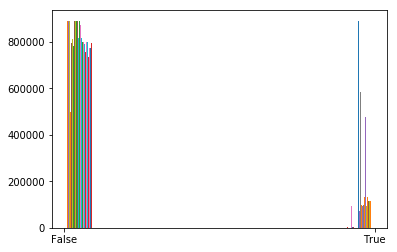

In [9]:
# Perform an assessment of how much missing data there is in each column of the
plt.hist(azdias_dup.isnull())
plt.legend
plt.show

In [10]:
null_temp = pd.DataFrame(azdias_dup.isnull().sum())
null_temp.columns = ['Null_Count']

In [11]:
null_temp.query('Null_Count > 200000')

,Null_Count
AGER_TYP,685843
GEBURTSJAHR,392318
TITEL_KZ,889061
ALTER_HH,310267
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524


In [12]:
# Investigate patterns in the amount of missing data in each column.
azdias_dup['AGER_TYP'].value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

In [13]:
azdias_dup['GEBURTSJAHR'].value_counts()

1967.0    11183
1965.0    11090
1966.0    10933
1970.0    10883
1964.0    10799
1968.0    10792
1963.0    10513
1969.0    10360
1980.0    10275
1962.0    10082
1961.0     9880
1971.0     9786
1982.0     9516
1978.0     9509
1960.0     9492
1979.0     9422
1981.0     9374
1977.0     9296
1959.0     9098
1972.0     9027
1976.0     9005
1983.0     8887
1974.0     8676
1984.0     8553
1975.0     8480
1973.0     8356
1958.0     8323
1986.0     8192
1985.0     8180
1957.0     8099
          ...  
2009.0      559
2008.0      550
2010.0      545
2011.0      485
1923.0      468
2013.0      380
1922.0      375
1921.0      355
2015.0      257
1920.0      238
1919.0      194
2016.0      167
2014.0      124
1918.0       85
1917.0       55
1914.0       55
1916.0       45
1910.0       41
1913.0       39
1915.0       37
1911.0       30
1912.0       28
1905.0        8
1909.0        7
1908.0        7
1906.0        7
1904.0        5
1907.0        4
1900.0        4
1902.0        1
Name: GEBURTSJAHR, Lengt

In [14]:
azdias_dup['TITEL_KZ'].value_counts()

1.0    1947
5.0     104
4.0      57
3.0      49
2.0       3
Name: TITEL_KZ, dtype: int64

In [15]:
azdias_dup['ALTER_HH'].value_counts()

18.0    60852
17.0    55665
19.0    52890
15.0    51867
16.0    51857
14.0    44275
21.0    41610
20.0    40671
13.0    37612
12.0    34923
10.0    30419
11.0    27924
9.0     22817
8.0     13463
7.0      8419
6.0      3809
5.0      1030
4.0       603
3.0       200
2.0        47
1.0         1
Name: ALTER_HH, dtype: int64

In [16]:
azdias_dup['KK_KUNDENTYP'].value_counts()

3.0    65151
2.0    62564
5.0    48038
4.0    44512
6.0    44114
1.0    42230
Name: KK_KUNDENTYP, dtype: int64

In [17]:
azdias_dup['KBA05_BAUMAX'].value_counts()

1.0    208417
5.0     98923
3.0     59955
4.0     37718
2.0      9684
Name: KBA05_BAUMAX, dtype: int64

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# azdias_dup.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1)
azdias_dup.pop('AGER_TYP')
azdias_dup.pop('GEBURTSJAHR')
azdias_dup.pop('TITEL_KZ')
azdias_dup.pop('ALTER_HH')
azdias_dup.pop('KK_KUNDENTYP')
azdias_dup.pop('KBA05_BAUMAX')
azdias_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS

#### Discussion 1.1.2: Assess Missing Data in Each Column

Out of all the columns that had null values there were 6 of them that made up the overwhelming majority listed below: 

AGER_TYP = Best Age Typology <br>
GEBURTSJAHR = Year of Birth <br>
TITEL_KZ = Academic Title <br>
ALTER_HH = Birthdate of head of household <br>
KK_KUNDENTYP = Consumer pattern over past 12 months <br>
KBA05_BAUMAX = Most common building type w/in a microcell <br>

Since these columns were the biggest outliers, they were removed from the dataset. For the remainder of the columns they were pretty consistently filled in with some being better than others but overall there should be enough information available to use them. Most of the categories were pretty consistent as well in terms of having the same amount of null values. For example all the Financial and Personality columns had the same number of null values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
null_df = pd.DataFrame(azdias_dup.isnull().sum(axis=1))
null_df.columns = ['null_count']
null_df.head()

,null_count
0,43
1,0
2,0
3,7
4,0


In [20]:
null_df.describe()

,null_count
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


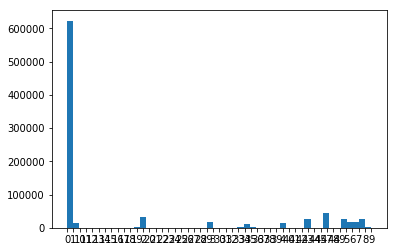

In [21]:
null_df['null_count'].value_counts()
plt.hist(null_df, bins = 50)
plt.rcParams["figure.figsize"] = (20,7)
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_dup = pd.concat([azdias_dup, null_df], axis=1, join='inner')
azdias_dup.info()

# Reference: For concat function with dataframes: https://www.geeksforgeeks.org/how-to-combine-two-dataframe-in-python-pandas/

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS

In [23]:
# Will break the datasets up between no null and values with nulls.
azdias_under = azdias_dup.query('null_count <= 20')
azdias_under.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     794642 non-null float64
ANREDE_KZ                797426 non-null float64
CJT_GESAMTTYP            792792 non-null float64
FINANZ_MINIMALIST        797426 non-null float64
FINANZ_SPARER            797426 non-null float64
FINANZ_VORSORGER         797426 non-null float64
FINANZ_ANLEGER           797426 non-null float64
FINANZ_UNAUFFAELLIGER    797426 non-null float64
FINANZ_HAUSBAUER         797426 non-null float64
FINANZTYP                797426 non-null float64
GFK_URLAUBERTYP          792792 non-null float64
GREEN_AVANTGARDE         797426 non-null int64
HEALTH_TYP               761009 non-null float64
LP_LEBENSPHASE_FEIN      747775 non-null float64
LP_LEBENSPHASE_GROB      750596 non-null float64
LP_FAMILIE_FEIN          766305 non-null float64
LP_FAMILIE_GROB          766305 non-null float64
LP_STATUS_FEIN           792792 non-null float64
LP_STATUS

In [24]:
azdias_over = azdias_dup.query('null_count > 20')
azdias_over.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93795 entries, 0 to 891187
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     93698 non-null float64
ANREDE_KZ                93795 non-null float64
CJT_GESAMTTYP            93575 non-null float64
FINANZ_MINIMALIST        93795 non-null float64
FINANZ_SPARER            93795 non-null float64
FINANZ_VORSORGER         93795 non-null float64
FINANZ_ANLEGER           93795 non-null float64
FINANZ_UNAUFFAELLIGER    93795 non-null float64
FINANZ_HAUSBAUER         93795 non-null float64
FINANZTYP                93795 non-null float64
GFK_URLAUBERTYP          93575 non-null float64
GREEN_AVANTGARDE         93795 non-null int64
HEALTH_TYP               19016 non-null float64
LP_LEBENSPHASE_FEIN      45814 non-null float64
LP_LEBENSPHASE_GROB      46053 non-null float64
LP_FAMILIE_FEIN          47124 non-null float64
LP_FAMILIE_GROB          47124 non-null float64
LP_STATUS_FEIN           93575 non-null float64
LP_STATUS_GROB           935

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def subplot_graphs(column):
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data = azdias_under)

    plt.subplot(1, 2, 2)
    sns.countplot(x=column, data = azdias_over)

    plt.tight_layout(4)

    plt.show()
    
    return

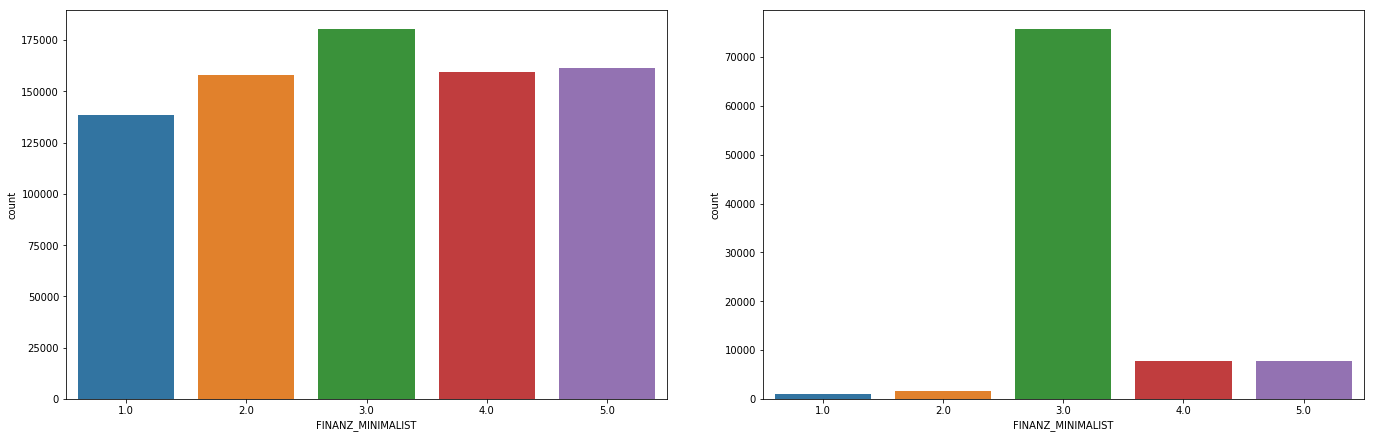

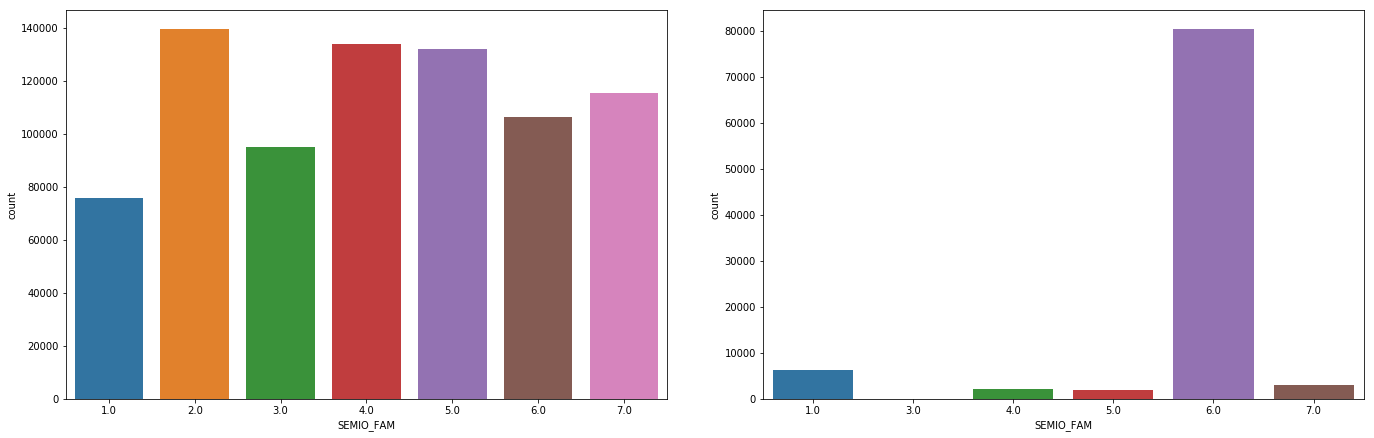

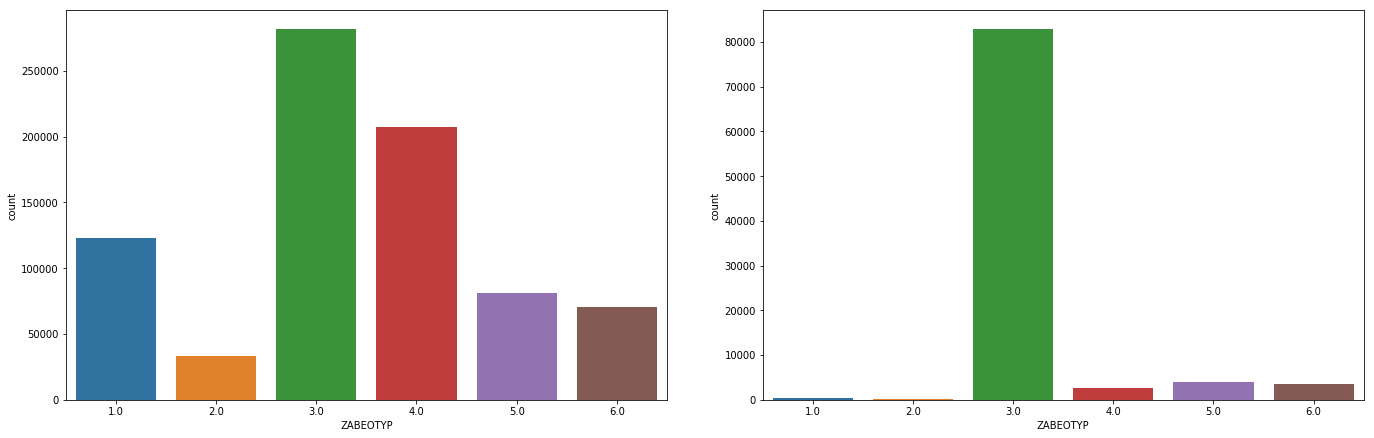

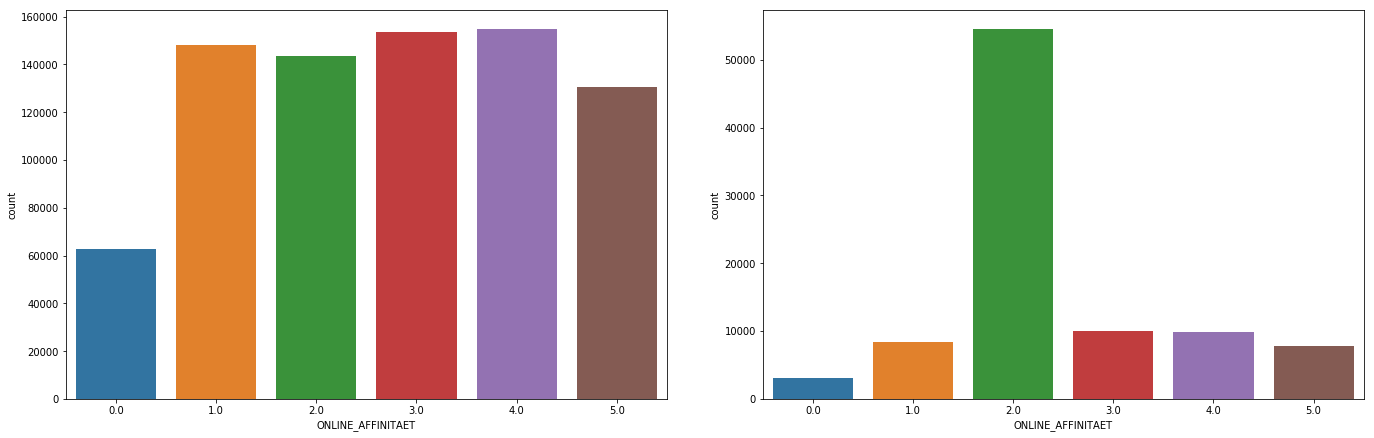

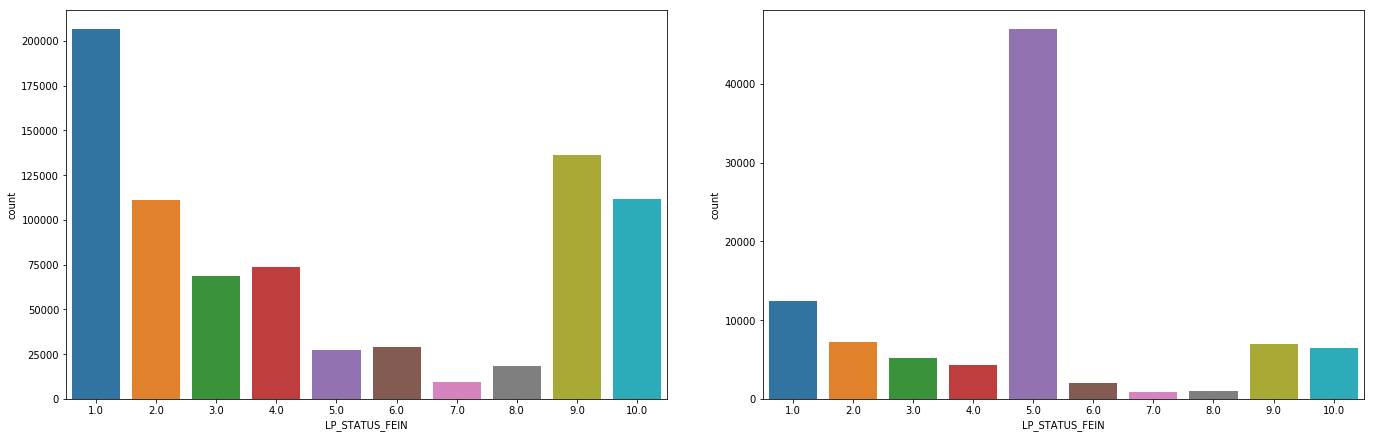

In [26]:
subplot_graphs('FINANZ_MINIMALIST')
subplot_graphs('SEMIO_FAM')
subplot_graphs('ZABEOTYP')
subplot_graphs('ONLINE_AFFINITAET')
subplot_graphs('LP_STATUS_FEIN')

#### Discussion 1.1.3: Assess Missing Data in Each Row

When we look at the two datasets we do see that there are some differences in the proportion of data in the selected columns. For example the FINANZ_MINIMALIST field has a relatively even distribution of records for the under dataset, while the over dataset is primiarly made up of values with 3.0. Similiarities such as that are showing within the next 4 charts as well, with the distribution being different across both datasets. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
temp_ctgs = pd.DataFrame(feat_info.query('type == "categorical"'))
temp_ctgs = temp_ctgs.reindex(columns = temp_ctgs.columns.tolist() + ['ctg_num','ctg_values'])
temp_ctgs.head(21)

,attribute,information_level,type,missing_or_unknown,ctg_num,ctg_values
0,AGER_TYP,person,categorical,"[-1,0]",NaN,NaN
2,ANREDE_KZ,person,categorical,"[-1,0]",NaN,NaN
3,CJT_GESAMTTYP,person,categorical,[0],NaN,NaN
10,FINANZTYP,person,categorical,[-1],NaN,NaN
12,GFK_URLAUBERTYP,person,categorical,[],NaN,NaN
13,GREEN_AVANTGARDE,person,categorical,[],NaN,NaN
17,LP_FAMILIE_FEIN,person,categorical,[0],NaN,NaN
18,LP_FAMILIE_GROB,person,categorical,[0],NaN,NaN
19,LP_STATUS_FEIN,person,categorical,[0],NaN,NaN
20,LP_STATUS_GROB,person,categorical,[0],NaN,NaN


In [29]:
def fill_cat_nulls(column, df): 
    df_median = df[column].median()
    df[column] = df[column].fillna(value=df_median)
    
    return df_median

In [30]:
removed_cols = {'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'}
for i, row in temp_ctgs.iterrows():
    column = temp_ctgs['attribute'][i]
    if column not in removed_cols:
        ctg_num = len(azdias_under[column].unique())
        uniq_values = str(azdias_under[column].unique())
        temp_ctgs['ctg_num'][i] = ctg_num
        temp_ctgs['ctg_values'][i] = uniq_values

temp_ctgs.head(21)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,attribute,information_level,type,missing_or_unknown,ctg_num,ctg_values
0,AGER_TYP,person,categorical,"[-1,0]",NaN,NaN
2,ANREDE_KZ,person,categorical,"[-1,0]",2.0,[ 2. 1.]
3,CJT_GESAMTTYP,person,categorical,[0],7.0,[ 5. 3. 2. 4. 1. 6. nan]
10,FINANZTYP,person,categorical,[-1],6.0,[ 1. 6. 5. 2. 4. 3.]
12,GFK_URLAUBERTYP,person,categorical,[],13.0,[ 10. 1. 5. 12. 9. 3. 8. 11. 4. ...
13,GREEN_AVANTGARDE,person,categorical,[],2.0,[0 1]
17,LP_FAMILIE_FEIN,person,categorical,[0],12.0,[ 5. 1. nan 10. 2. 7. 11. 8. 4. ...
18,LP_FAMILIE_GROB,person,categorical,[0],6.0,[ 3. 1. nan 5. 2. 4.]
19,LP_STATUS_FEIN,person,categorical,[0],11.0,[ 2. 3. 9. 4. 1. 10. 5. 8. 6. ...
20,LP_STATUS_GROB,person,categorical,[0],6.0,[ 1. 2. 4. 5. 3. nan]


In [31]:
from sklearn.preprocessing import OneHotEncoder

def encoding_df(df_enc, column):
    
    fill_cat_nulls(column, df_enc)
    dummy_df = pd.DataFrame(pd.get_dummies(df_enc[column], prefix=None))
    df_enc = df_enc.join(dummy_df)
    
    #OHE = OneHotEncoder(handle_unknown='ignore')
    #OHE_df = pd.DataFrame(OHE.fit_transform(df_enc[[column]]).toarray())
    #OHE_df.columns = OHE.feature_names_in_([column])
    #df_enc = df_enc.join(OHE_df)
    df_enc.pop(column)
    
    return df_enc

In [32]:
azdias_under = encoding_df(azdias_under, 'CJT_GESAMTTYP')
azdias_under = azdias_under.rename(columns={1:'consumption_minimalist', \
                                           2:'consumption_traditionalist', \
                                           3:'store_shopper', \
                                           4:'online_shopper', \
                                           5:'cross_channel_enthusiast', \
                                           6:'restricted_CC_enthusiast'})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
azdias_under = encoding_df(azdias_under, 'FINANZTYP')
azdias_under = azdias_under.rename(columns={1:'low_financial_interest', \
                                           2:'money_saver', \
                                           3:'home_ownership', \
                                           4:'be_prepared', \
                                           5:'investor', \
                                           6:'inconspicuous'})

In [34]:
azdias_under = encoding_df(azdias_under, 'GFK_URLAUBERTYP')
azdias_under = azdias_under.rename(columns={1:'event_travelers', \
                                           2:'family_oriented_vacationist', \
                                           3:'winter_sportspeople', \
                                           4:'culture_lovers', \
                                           5:'nature_fans', \
                                           6:'hiker', \
                                           7:'golden_ager', \
                                           8:'homeland_connected_vacationist', \
                                           9:'package_tour_traveler', \
                                           10:'connoisseurs', \
                                           11:'active_families', \
                                           12:'without_vacation'})

In [35]:
azdias_under = encoding_df(azdias_under, 'LP_FAMILIE_FEIN')
azdias_under = azdias_under.rename(columns={1:'fs_single', \
                                           2:'fs_couple', \
                                           3:'fs_young_single_parent', \
                                           4:'fs_singe_par_w_teen', \
                                           5:'fs_single_par_w_child_full_age', \
                                           6:'fs_young_family', \
                                           7:'fs_family_w_teenager', \
                                           8:'fs_family_w_child_full_age', \
                                           9:'fs_shared_flat', \
                                           10:'fs_two_generational_household', \
                                           11:'fs_multi_generational_household'})

In [36]:
azdias_under = encoding_df(azdias_under, 'LP_FAMILIE_GROB')
azdias_under = azdias_under.rename(columns={1:'rs_single', \
                                           2:'rs_couple', \
                                           3:'rs_single_parent', \
                                           4:'rs_family', \
                                           5:'rs_multiperson_household'})

In [37]:
azdias_under = encoding_df(azdias_under, 'LP_STATUS_FEIN')
azdias_under = azdias_under.rename(columns={1:'fs_low_income_earners', \
                                           2:'fs_orientation_low_income_earners', \
                                           3:'fs_aspiring_low_income_earners', \
                                           4:'fs_villagers', \
                                           5:'fs_minimalistic_high_income_earners', \
                                           6:'fs_independent_workers', \
                                           7:'fs_title_holder_households', \
                                           8:'fs_new_houseowners', \
                                           9:'fs_new_houseowners', \
                                           10:'fs_houseowners'})

In [38]:
azdias_under = encoding_df(azdias_under, 'LP_STATUS_GROB')
azdias_under = azdias_under.rename(columns={1:'rs_low_income_earners', \
                                            2:'rs_average_earners', \
                                           3:'rs_independents', \
                                           4:'rs_houseowners', \
                                           5:'rs_top_earners'})

In [39]:
azdias_under = encoding_df(azdias_under, 'NATIONALITAET_KZ')
azdias_under = azdias_under.rename(columns={1:'german_sounding', \
                                           2:'foreign_sounding', \
                                           3:'assimilated_names'})

In [40]:
azdias_under = encoding_df(azdias_under, 'SHOPPER_TYP')
azdias_under = azdias_under.rename(columns={0:'external_supplied_hedonist', \
                                            1:'shopping_stressed', \
                                           2:'family_shopper', \
                                           3:'demanding_shopper'})

In [41]:
azdias_under = encoding_df(azdias_under, 'VERS_TYP')
azdias_under = azdias_under.rename(columns={1:'social_saftey_driven', \
                                            2:'individ_accepting_risks'})

In [42]:
azdias_under = encoding_df(azdias_under, 'ZABEOTYP')
azdias_under = azdias_under.rename(columns={1:'green', \
                                           2:'smart', \
                                           3:'fair_supplied', \
                                           4:'price_driven', \
                                           5:'seeking_orientation', \
                                           6:'indifferent'})

In [43]:
azdias_under = encoding_df(azdias_under, 'GEBAEUDETYP')
azdias_under = azdias_under.rename(columns={1:'residential_building', \
                                            2:'residential_building_unknown_household', \
                                            3:'mixed_building', \
                                            4:'mixed_building_unknown_company_household', \
                                            5:'company_building_unknown_company', \
                                            6:'mixed_building_known_household', \
                                            7:'company_building', \
                                            8:'mixed_building_unknown_company'})

In [44]:
azdias_dup['CAMEO_DEUG_2015'].value_counts()

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
Name: CAMEO_DEUG_2015, dtype: int64

In [45]:
updateW = azdias_under['OST_WEST_KZ'] == 'W'
azdias_under.loc[updateW, 'OST_WEST_KZ'] = 1
updateO = azdias_under['OST_WEST_KZ'] == 'O'
azdias_under.loc[updateO, 'OST_WEST_KZ'] = 0

In [46]:
azdias_under = encoding_df(azdias_under, 'CAMEO_DEUG_2015')
azdias_under = azdias_under.rename(columns={'1':'upper_class', \
                                            '2':'upper_middleclass', \
                                            '3':'established_middleclass', \
                                            '4':'consumption_oriented_middleclass', \
                                            '5':'active_middleclass', \
                                            '6':'low_consumption_middleclass', \
                                            6: 'low_consumption_middleclass', \
                                            '7':'lower_middleclass', \
                                            '8':'working_class', \
                                            '9':'urban_working_class'})

In [47]:
codes = {'1A': 1, '1B': 2, '1C': 3, '1D': 4, '1E': 5, '2A': 6, '2B': 7, '2C': 8, '2D': 9, '3A': 10, \
         '3B': 11, '3C': 12, '3D': 13, '4A': 14, '4B': 15, '4C': 16, '4D': 17, '4E': 18, '5A': 19, \
         '5B': 20, '5C': 21, '5D': 22, '5E': 23, '5F': 24, '6A': 25, '6B': 26, '6C': 27, '6D': 28, \
         '6E': 29, '6F': 30, '7A': 31, '7B': 32, '7C': 33, '7D': 34, '7E': 35, '8A': 36, '8B': 37, \
         '8C': 38, '8D': 39, '9A': 40, '9B': 41, '9C': 42, '9D': 43, '9E': 44}

uniques = azdias_under['CAMEO_DEU_2015'].unique()
cd2015 = []
for i in uniques:
    cd2015.append(i)
    
cd2015.remove(np.nan)

i = 0

while i < len(cd2015):
    update = cd2015[i]
    if update != '0':
        indexes = azdias_under['CAMEO_DEU_2015'] == update
        azdias_under.loc[indexes, 'CAMEO_DEU_2015'] = codes[update]
        
    i += 1

In [48]:
azdias_under = encoding_df(azdias_under, 'CAMEO_DEU_2015')

In [49]:
definition = {1: 'work_life_balance', 2: 'wealthy_best_ager', 3: 'successful_songwriter', 4: 'old_nobility', \
              5: 'city_nobility', 6: 'cottage_chic', 7: 'noble_jogger', 8: 'established_gourmet', \
              9: 'fine_management', 10: 'career_and_family', 11: 'powershopping_families', 12: 'rural_neighborhoods', \
              13: 'secure_retirement', 14: 'family_starter', 15: 'family_life', 16: 'string_trimmer', 17: 'empty_nest', \
              18: 'golden_age_person', 19: 'younger_employees', 20: 'suddenly_family', 21: 'family_first', 22: 'stock_market_junkies', \
              23: 'coffee_rider', 24: 'active_retirement', 25: 'jobstarter', 26: 'petty_bourgeois', 27: 'long_established', \
              28: 'sportgardener', 29: 'urban_parents', 30: 'frugal_aging', 31: 'journeymen', 32: 'mantaplatte', \
              33: 'factory_worker', 34: 'rear_window', 35: 'interested_retirees', 36: 'multi_culteral', 37: 'young_mobile', \
              38: 'prefab', 39: 'town_seniors', 40: 'first_shared_apt', 41: 'temporary_workers', 42:'afternoon_talk_show', \
              43: 'mini_jobber', 44: 'socking_away'}

i = 1
while i <= len(cd2015):
        column_name = definition[i]
        encoded_col = i
        azdias_under = azdias_under.rename(columns={encoded_col:column_name})
        i += 1

In [50]:
my_list = azdias_under.columns.values.tolist()
print(my_list)

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBE

#### Discussion 1.2.1: Re-Encode Categorical Features
So Ager_Type, TITEL_KZ, and KK_KUNDENTYP were removed from the dataset due to there being to many null values so they were not included. Overall i was able to one hot encode the other categorical values by finding what values are in there dataset and using the data dictionary to give them more descriptive names once they the encoding was completed. Most values were already in the numbered format but for the CAMEO_DEU_2015 column that used specific codes they had to be converted for the one hot encoding to work. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [51]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_under['decade'] = np.NaN
azdias_under['movement'] = np.NaN

azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] > 0) & (azdias_under['PRAEGENDE_JUGENDJAHRE'] < 3), 'decade'] = '40'
azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] > 2) & (azdias_under['PRAEGENDE_JUGENDJAHRE'] < 5), 'decade'] = '50'
azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] > 4) & (azdias_under['PRAEGENDE_JUGENDJAHRE'] < 8), 'decade'] = '60'
azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] > 7) & (azdias_under['PRAEGENDE_JUGENDJAHRE'] < 10), 'decade'] = '70'
azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] > 9) & (azdias_under['PRAEGENDE_JUGENDJAHRE'] < 14), 'decade'] = '80'
azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] > 13) & (azdias_under['PRAEGENDE_JUGENDJAHRE'] < 16), 'decade'] = '90'

mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

i = 0
while i < len(mainstream):
    azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] == mainstream[i]), 'movement'] = '0'
    i += 1

i = 0
while i < len(avantgarde):
    azdias_under.loc[(azdias_under['PRAEGENDE_JUGENDJAHRE'] == avantgarde[i]), 'movement'] = '1'
    i += 1

azdias_under['decade'].unique()

array(['90', '70', '50', '80', '60', nan, '40'], dtype=object)

In [52]:
azdias_under['movement'].unique()

array(['0', '1', nan], dtype=object)

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_under['household'] = azdias_under['CAMEO_INTL_2015'].str[0]
azdias_under['household_details'] = azdias_under['CAMEO_INTL_2015'].str[1]

In [54]:
azdias_under.pop('PRAEGENDE_JUGENDJAHRE')
azdias_under.pop('CAMEO_INTL_2015')
azdias_under.pop('null_count')

1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
12         6
13         8
15         8
16         6
18         3
19         0
20        10
21         0
22         0
23         8
25         5
26        19
27         0
28         0
29         2
31         0
32         0
33         0
34         4
36         0
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Name: null_count, Length: 797426, dtype: int64

In [55]:
azdias_under.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Columns: 198 entries, ALTERSKATEGORIE_GROB to household_details
dtypes: float64(61), int64(2), object(4), uint8(131)
memory usage: 513.3+ MB


In [56]:
col_list = azdias_under.columns.values.tolist()
print(col_list)

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'consumption

#### Discussion 1.2.2: Engineer Mixed-Type Features
To address the mixed-value columns I added columns that were specfiic to those particular variables (decade, movement, household, and household details). Then updated the values in those fields based on the information that was in the original column. After that was completed, i removed the original columns from the data set as they were no longer neccesary. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [57]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Process taken care of above. 


In [58]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Process taken care of above. 


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [59]:
def check_columns(df, col_list):
    for i in col_list:
        match = False
        for j in df.columns:
            if i == j:
                match = True
    
        if match == False:
            df[i] = float(0.0)
            
    return

In [60]:
def clean_data(df, col_list):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")
    
    for i, row in feat_info.iterrows():
        column = feat_info['attribute'][i]
        missing_unknown = feat_info['missing_or_unknown'][i]
        options = missing_unknown.strip('][').split(',')
        # Condition if there are no actual values in the missing_or_unknown field. 
        if options[0] != '':
            j = 0
            k = len(options)
            while j < k:
            # Determines the datatype of the current column in the azdias dataset so 
            # we can match it with the appropriate variable type of the value taken 
            # from the missing_or_unknown field. 
                if df[column].dtype == 'object':
                    option_val = options[j]
                elif df[column].dtype == 'float64':
                    option_val = pd.to_numeric(options[j])
                else:
                    option_val = int(options[j])
                matches = df[column] == option_val
                df.loc[matches, column] = np.NaN
                j += 1

    df.pop('AGER_TYP')
    df.pop('GEBURTSJAHR')
    df.pop('TITEL_KZ')
    df.pop('ALTER_HH')
    df.pop('KK_KUNDENTYP')
    df.pop('KBA05_BAUMAX')

    null_df = pd.DataFrame(df.isnull().sum(axis=1))
    null_df.columns = ['null_count']
    df = pd.concat([df, null_df], axis=1, join='inner')
    df_under = df.query('null_count >= 20')

    temp_ctgs = pd.DataFrame(feat_info.query('type == "categorical"'))
    temp_ctgs = temp_ctgs.reindex(columns = temp_ctgs.columns.tolist() + ['ctg_num','ctg_values'])
    removed_cols = {'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'}
    for i, row in temp_ctgs.iterrows():
        column = temp_ctgs['attribute'][i]
        if column not in removed_cols:
            ctg_num = len(df[column].unique())
            uniq_values = str(df[column].unique())
            temp_ctgs['ctg_num'][i] = ctg_num
            temp_ctgs['ctg_values'][i] = uniq_values

    df_under = encoding_df(df_under, 'CJT_GESAMTTYP')
    df_under = df_under.rename(columns={1:'consumption_minimalist', \
                                        2:'consumption_traditionalist', \
                                        3:'store_shopper', \
                                        4:'online_shopper', \
                                        5:'cross_channel_enthusiast', \
                                        6:'restricted_CC_enthusiast'})
    
    CJT_GESAMTTYP_cols = ['consumption_minimalist', 'consumption_traditionalist', \
                         'store_shopper', 'online_shopper', 'cross_channel_enthusiast', \
                         'restricted_CC_enthusiast']
    check_columns(df_under, CJT_GESAMTTYP_cols)

    df_under = encoding_df(df_under, 'FINANZTYP')
    df_under = df_under.rename(columns={1:'low_financial_interest', \
                                        2:'money_saver', \
                                        3:'home_ownership', \
                                        4:'be_prepared', \
                                        5:'investor', \
                                        6:'inconspicuous'})
    
    FINANZTYP_cols = ['low_financial_interest', 'money_saver', 'home_ownership', \
                     'be_prepared', 'investor', 'inconspicuous']
    check_columns(df_under, FINANZTYP_cols)

    df_under = encoding_df(df_under, 'GFK_URLAUBERTYP')
    df_under = df_under.rename(columns={1:'event_travelers', \
                                        2:'family_oriented_vacationist', \
                                        3:'winter_sportspeople', \
                                        4:'culture_lovers', \
                                        5:'nature_fans', \
                                        6:'hiker', \
                                        7:'golden_ager', \
                                        8:'homeland_connected_vacationist', \
                                        9:'package_tour_traveler', \
                                        10:'connoisseurs', \
                                        11:'active_families', \
                                        12:'without_vacation'})
    
    GFK_URLAUBERTYP_cols = ['event_travelers', 'family_oriented_vacationist', 'winter_sportspeople' \
                           'culture_lovers', 'nature_fans', 'hiker', 'golden_ager', \
                            'homeland_connected_vacationist', 'package_tour_traveler', 'connoisseurs' \
                           'active_families', 'without_vacation']
    check_columns(df_under, GFK_URLAUBERTYP_cols)

    df_under = encoding_df(df_under, 'LP_FAMILIE_FEIN')
    df_under = df_under.rename(columns={1:'fs_single', \
                                        2:'fs_couple', \
                                        3:'fs_young_single_parent', \
                                        4:'fs_singe_par_w_teen', \
                                        5:'fs_single_par_w_child_full_age', \
                                        6:'fs_young_family', \
                                        7:'fs_family_w_teenager', \
                                        8:'fs_family_w_child_full_age', \
                                        9:'fs_shared_flat', \
                                        10:'fs_two_generational_household', \
                                        11:'fs_multi_generational_household'})
    
    LP_FAMILIE_FEIN_cols = ['fs_single', 'fs_couple', 'fs_young_single_parent', \
                           'fs_singe_par_w_teen', 'fs_single_par_w_child_full_age', \
                           'fs_young_family', 'fs_family_w_teenager', 'fs_family_w_child_full_age', \
                           'fs_shared_flat', 'fs_two_generational_household', \
                            'fs_multi_generational_household']
    check_columns(df_under, LP_FAMILIE_FEIN_cols)

    df_under = encoding_df(df_under, 'LP_FAMILIE_GROB')
    df_under = df_under.rename(columns={1:'rs_single', \
                                        2:'rs_couple', \
                                        3:'rs_single_parent', \
                                        4:'rs_family', \
                                        5:'rs_multiperson_household'})
    
    LP_FAMILIE_GROB_cols = ['rs_single', 'rs_couple', 'rs_single_parent', 'rs_family', \
                           'rs_multiperson_household']
    check_columns(df_under, LP_FAMILIE_GROB_cols)

    df_under = encoding_df(df_under, 'LP_STATUS_FEIN')
    df_under = df_under.rename(columns={1:'fs_low_income_earners', \
                                           2:'fs_orientation_low_income_earners', \
                                           3:'fs_aspiring_low_income_earners', \
                                           4:'fs_villagers', \
                                           5:'fs_minimalistic_high_income_earners', \
                                           6:'fs_independent_workers', \
                                           7:'fs_title_holder_households', \
                                           8:'fs_new_houseowners', \
                                           9:'fs_houseowners', \
                                           10:'fs_top_earners'})
    
    LP_STATUS_FEIN_cols = ['fs_low_income_earners', 'fs_orientation_low_income_earners', \
                          'fs_aspiring_low_income_earners', 'fs_villagers', \
                          'fs_minimalistic_high_income_earners', 'fs_independent_workers', \
                          'fs_title_holder_households', 'fs_new_houseowners', 'fs_houseowners', \
                          'fs_top_earners']
    check_columns(df_under, LP_STATUS_FEIN_cols)

    df_under = encoding_df(df_under, 'LP_STATUS_GROB')
    df_under = df_under.rename(columns={1:'rs_low_income_earners', \
                                        2:'rs_average_earners', \
                                        3:'rs_independents', \
                                        4:'rs_houseowners', \
                                        5:'rs_top_earners'})
    LP_STATUS_GROB_cols = ['rs_low_income_earners', 'rs_average_earners', 'rs_independents', \
                          'rs_houseowners', 'rs_top_earners']
    check_columns(df_under, LP_STATUS_GROB_cols)

    df_under = encoding_df(df_under, 'NATIONALITAET_KZ')
    df_under = df_under.rename(columns={1:'german_sounding', \
                                        2:'foreign_sounding', \
                                        3:'assimilated_names'})
    NATIONALITAET_KZ_cols = ['german_sounding', 'foreign_sounding', 'assimilated_names']
    check_columns(df_under, NATIONALITAET_KZ_cols)

    df_under = encoding_df(df_under, 'SHOPPER_TYP')
    df_under = df_under.rename(columns={0:'external_supplied_hedonist', \
                                        1:'shopping_stressed', \
                                        2:'family_shopper', \
                                        3:'demanding_shopper'})
                                        
    SHOPPER_TYP_cols = ['external_supplied_hedonist', 'shopping_stressed', \
                        'family_shopper', 'demanding_shopper']
    check_columns(df_under, SHOPPER_TYP_cols)

    df_under = encoding_df(df_under, 'VERS_TYP')
    df_under = df_under.rename(columns={1:'social_saftey_driven', \
                                        2:'individ_accepting_risks'})
                                        
    VERS_TYP_cols = ['social_saftey_driven', 'individ_accepting_risks']
    check_columns(df_under, VERS_TYP_cols)

    df_under = encoding_df(df_under, 'ZABEOTYP')
    df_under = df_under.rename(columns={1:'green', \
                                        2:'smart', \
                                        3:'fair_supplied', \
                                        4:'price_driven', \
                                        5:'seeking_orientation', \
                                        6:'indifferent'})
    ZABEOTYP_cols = ['green', 'smart', 'fair_supplied', 'price_driven', 'seeking_orientation', \
                    'indifferent']
    check_columns(df_under, ZABEOTYP_cols)

    df_under = encoding_df(df_under, 'GEBAEUDETYP')
    df_under = df_under.rename(columns={1:'residential_building', \
                                        2:'residential_building_unknown_household', \
                                        3:'mixed_building', \
                                        4:'mixed_building_unknown_company_household', \
                                        5:'company_building_unknown_company', \
                                        6:'mixed_building_known_household', \
                                        7:'company_building', \
                                        8:'mixed_building_unknown_company'})
                                        
    GEBAEUDETYP_cols = ['residential_building', 'residential_building_unknown_household', \
                       'mixed_building', 'mixed_building_unknown_company_household', \
                       'company_building_unknown_company', 'mixed_building_known_household', \
                       'company_building', 'mixed_building_unknown_company']
    check_columns(df_under, GEBAEUDETYP_cols)

    updateW = df_under['OST_WEST_KZ'] == 'W'
    df_under.loc[updateW, 'OST_WEST_KZ'] = 1
    updateO = df_under['OST_WEST_KZ'] == 'O'
    df_under.loc[updateO, 'OST_WEST_KZ'] = 0

    df_under = encoding_df(df_under, 'CAMEO_DEUG_2015')
    df_under = df_under.rename(columns={1:'upper_class', \
                                        2:'upper_middleclass', \
                                        3:'established_middleclass', \
                                        4:'consumption_oriented_middleclass', \
                                        5:'active_middleclass', \
                                        6:'low_consumption_middleclass', \
                                        7:'lower_middleclass', \
                                        8:'working_class', \
                                        9:'urban_working_class'})
                                        
    CAMEO_DEUG_2015_cols = ['upper_class', 'upper_middleclass', 'established_middleclass', \
                           'consumption_oriented_middleclass', 'active_middleclass', \
                           'low_consumption_middleclass', 'lower_middleclass', 'working_class', \
                           'urban_working_class']
    check_columns(df_under, CAMEO_DEUG_2015_cols)

    codes = {'1A': 1, '1B': 2, '1C': 3, '1D': 4, '1E': 5, '2A': 6, '2B': 7, '2C': 8, '2D': 9, '3A': 10, \
         '3B': 11, '3C': 12, '3D': 13, '4A': 14, '4B': 15, '4C': 16, '4D': 17, '4E': 18, '5A': 19, \
         '5B': 20, '5C': 21, '5D': 22, '5E': 23, '5F': 24, '6A': 25, '6B': 26, '6C': 27, '6D': 28, \
         '6E': 29, '6F': 30, '7A': 31, '7B': 32, '7C': 33, '7D': 34, '7E': 35, '8A': 36, '8B': 37, \
         '8C': 38, '8D': 39, '9A': 40, '9B': 41, '9C': 42, '9D': 43, '9E': 44}

    uniques = df_under['CAMEO_DEU_2015'].unique()
    cd2015 = []
    for i in uniques:
        cd2015.append(i)
    
    cd2015.remove(np.NaN)

    i = 0
    while i < len(cd2015):
        update = cd2015[i]
        if update != '0':
            indexes = df_under['CAMEO_DEU_2015'] == update
            df_under.loc[indexes, 'CAMEO_DEU_2015'] = codes[update]
        
        i += 1
    
    df_under = encoding_df(df_under, 'CAMEO_DEU_2015')

    definition = {1: 'work_life_balance', 2: 'wealthy_best_ager', 3: 'successful_songwriter', 4: 'old_nobility', \
              5: 'city_nobility', 6: 'cottage_chic', 7: 'noble_jogger', 8: 'established_gourmet', \
              9: 'fine_management', 10: 'career_and_family', 11: 'powershopping_families', 12: 'rural_neighborhoods', \
              13: 'secure_retirement', 14: 'family_starter', 15: 'family_life', 16: 'string_trimmer', 17: 'empty_nest', \
              18: 'golden_age_person', 19: 'younger_employees', 20: 'suddenly_family', 21: 'family_first', 22: 'stock_market_junkies', \
              23: 'coffee_rider', 24: 'active_retirement', 25: 'jobstarter', 26: 'petty_bourgeois', 27: 'long_established', \
              28: 'sportgardener', 29: 'urban_parents', 30: 'frugal_aging', 31: 'journeymen', 32: 'mantaplatte', \
              33: 'factory_worker', 34: 'rear_window', 35: 'interested_retirees', 36: 'multi_culteral', 37: 'young_mobile', \
              38: 'prefab', 39: 'town_seniors', 40: 'first_shared_apt', 41: 'temporary_workers', 42:'afternoon_talk_show', \
              43: 'mini_jobber', 44: 'socking_away'}

    i = 1
    while i <= len(cd2015):
        column_name = definition[i]
        encoded_col = i
        df_under = df_under.rename(columns={encoded_col:column_name})
        i += 1
    
    
    CAMEO_DEU_2015_cols = list(definition.values())
    check_columns(df_under, CAMEO_DEU_2015_cols)
    
    df_under['decade'] = np.NaN
    df_under['movement'] = np.NaN

    df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] > 0) & (df_under['PRAEGENDE_JUGENDJAHRE'] < 3), 'decade'] = '40'
    df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] > 2) & (df_under['PRAEGENDE_JUGENDJAHRE'] < 5), 'decade'] = '50'
    df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] > 4) & (df_under['PRAEGENDE_JUGENDJAHRE'] < 8), 'decade'] = '60'
    df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] > 7) & (df_under['PRAEGENDE_JUGENDJAHRE'] < 10), 'decade'] = '70'
    df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] > 9) & (df_under['PRAEGENDE_JUGENDJAHRE'] < 14), 'decade'] = '80'
    df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] > 13) & (df_under['PRAEGENDE_JUGENDJAHRE'] < 16), 'decade'] = '90'

    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    i = 0
    while i < len(mainstream):
        df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] == mainstream[i]), 'movement'] = '0'
        i += 1

    i = 0
    while i < len(avantgarde):
        df_under.loc[(df_under['PRAEGENDE_JUGENDJAHRE'] == avantgarde[i]), 'movement'] = '1'
        i += 1

    df_under['household'] = df_under['CAMEO_INTL_2015'].str[0]
    df_under['household_details'] = df_under['CAMEO_INTL_2015'].str[1]

    df_under.pop('PRAEGENDE_JUGENDJAHRE')
    df_under.pop('CAMEO_INTL_2015')
    df_under.pop('null_count')
    
    for col in col_list:
        match = False
        for j in df_under.columns:
            if col == j:
                match = True
    
        if match == False:
            final_df2[col] = float(0.0)
    
    df_under = df_under.reindex(columns=col_list)
                                        
    return df_under
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [61]:
azdias_under.dtypes
azdias_under.isnull().sum()

ALTERSKATEGORIE_GROB      2784
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               36417
LP_LEBENSPHASE_FEIN      49651
LP_LEBENSPHASE_GROB      46830
RETOURTYP_BK_S            4634
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
ANZ_PERSONEN                 0
ANZ_TITEL                    0
                         ...  
younger_employees            0
suddenly

In [62]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

azdias_under_test = azdias_under.astype(float)
imp = Imputer(strategy="mean")
azdias_under_test_imputed = imp.fit_transform(azdias_under_test)

In [63]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

feat_scale = StandardScaler(with_mean=0, with_std=1)
azdias_under_test_imputed = feat_scale.fit_transform(azdias_under_test_imputed)

In [64]:
azdias_under_test_imputed.shape

(797426, 198)

### Discussion 2.1: Apply Feature Scaling

One hot encoding seemed to bring some nulls into the dataset when being converted so those values had to be removed. This was important cause the feature scaling technique doens't work when null values are present. By replacing the nulls with the mean we are able to apply feature scaling. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
def run_pca(n, data):

    X = feat_scale.fit_transform(data)
    pca = PCA(n_components = n, random_state = 15)
    X_pca = pca.fit_transform(X)
    
    return pca, X_pca

In [66]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

#Using 30 as a starting point. 
pca, X_pca = run_pca(190, azdias_under_test_imputed)

print(pca.explained_variance_ratio_)

[  8.21991835e-02   5.66107070e-02   3.47550471e-02   3.01224558e-02
   2.38952262e-02   1.58381566e-02   1.48710457e-02   1.34464785e-02
   1.29329601e-02   1.24715547e-02   1.21852239e-02   1.18535429e-02
   1.16941353e-02   1.13622784e-02   1.11282313e-02   1.10377362e-02
   1.08307251e-02   1.06618191e-02   1.04824022e-02   1.02756626e-02
   1.01510945e-02   9.76686352e-03   9.50063024e-03   9.11153719e-03
   8.76523619e-03   8.46717110e-03   8.28318237e-03   8.15819908e-03
   7.56978230e-03   7.39361770e-03   7.24228086e-03   6.95915460e-03
   6.84402788e-03   6.78354661e-03   6.57730091e-03   6.44725343e-03
   6.42796300e-03   6.29886005e-03   6.25304388e-03   6.10006155e-03
   6.02335492e-03   5.92504768e-03   5.77489583e-03   5.69735674e-03
   5.63827725e-03   5.62865950e-03   5.58471999e-03   5.54379455e-03
   5.49137167e-03   5.44507790e-03   5.41510889e-03   5.38749820e-03
   5.34674218e-03   5.32327128e-03   5.29366845e-03   5.29311454e-03
   5.25752115e-03   5.24161910e-03

In [67]:
print(np.cumsum(pca.explained_variance_ratio_))

[ 0.08219918  0.13880989  0.17356494  0.20368739  0.22758262  0.24342078
  0.25829182  0.2717383   0.28467126  0.29714282  0.30932804  0.32118158
  0.33287572  0.344238    0.35536623  0.36640396  0.37723469  0.38789651
  0.39837891  0.40865457  0.41880567  0.42857253  0.43807316  0.4471847
  0.45594993  0.4644171   0.47270029  0.48085849  0.48842827  0.49582189
  0.50306417  0.51002332  0.51686735  0.5236509   0.5302282   0.53667545
  0.54310341  0.54940227  0.55565532  0.56175538  0.56777873  0.57370378
  0.57947868  0.58517603  0.59081431  0.59644297  0.60202769  0.60757149
  0.61306286  0.61850794  0.62392304  0.62931054  0.63465728  0.63998056
  0.64527422  0.65056734  0.65582486  0.66106648  0.66628312  0.67148903
  0.67668481  0.68187055  0.68704985  0.69222009  0.69737859  0.70252838
  0.70767472  0.71281372  0.71794239  0.72306711  0.72818618  0.73329591
  0.73840109  0.74350038  0.74859942  0.75369121  0.75878029  0.76386509
  0.76894668  0.77402229  0.77909515  0.78415967  0.

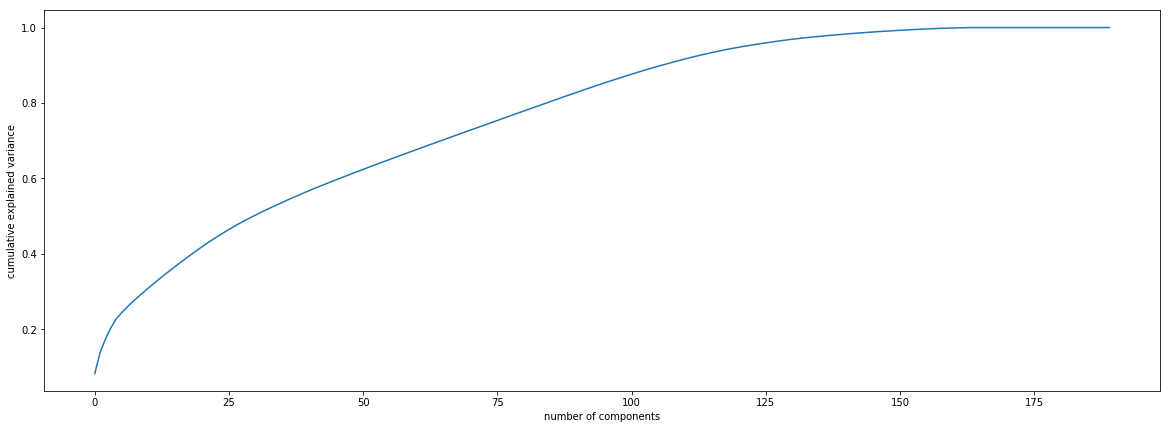

In [68]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [69]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = run_pca(113, azdias_under_test_imputed)

print(pca.explained_variance_ratio_)


[ 0.08219918  0.05661071  0.03475505  0.03012246  0.02389523  0.01583816
  0.01487105  0.01344648  0.01293296  0.01247155  0.01218522  0.01185354
  0.01169413  0.01136226  0.01112822  0.01103773  0.01083072  0.01066181
  0.01048239  0.01027566  0.01015106  0.00976684  0.00950062  0.00911151
  0.0087652   0.00846716  0.00828312  0.00815817  0.00756961  0.00739358
  0.00724211  0.00695898  0.00684386  0.00678347  0.00657704  0.00644575
  0.00642785  0.0062973   0.00625275  0.00609988  0.00602219  0.00592475
  0.00577405  0.00569705  0.00563682  0.00562757  0.00558408  0.00554269
  0.00548943  0.00544411  0.00541423  0.00538676  0.00534429  0.00532249
  0.00529264  0.00529154  0.00525531  0.0052406   0.00521537  0.00520422
  0.00519435  0.00518486  0.00517837  0.0051696   0.00515533  0.00514883
  0.00514458  0.00513884  0.0051274   0.00512325  0.00511752  0.00510828
  0.00510364  0.00509877  0.0050955   0.00509046  0.00508849  0.00508365
  0.00507929  0.00507319  0.00506743  0.00506137  0

In [70]:
print(np.cumsum(pca.explained_variance_ratio_))

[ 0.08219918  0.13880989  0.17356494  0.20368739  0.22758262  0.24342078
  0.25829182  0.2717383   0.28467126  0.29714281  0.30932803  0.32118157
  0.3328757   0.34423796  0.35536618  0.36640391  0.37723463  0.38789644
  0.39837883  0.40865449  0.41880555  0.42857239  0.43807301  0.44718453
  0.45594973  0.46441688  0.47270001  0.48085817  0.48842779  0.49582137
  0.50306349  0.51002246  0.51686632  0.52364979  0.53022683  0.53667258
  0.54310042  0.54939772  0.55565047  0.56175035  0.56777254  0.57369729
  0.57947135  0.58516839  0.59080521  0.59643278  0.60201686  0.60755955
  0.61304898  0.61849309  0.62390732  0.62929408  0.63463837  0.63996086
  0.64525349  0.65054503  0.65580034  0.66104094  0.66625631  0.67146053
  0.67665488  0.68183974  0.68701811  0.69218771  0.69734304  0.70249187
  0.70763645  0.71277529  0.71790269  0.72302593  0.72814346  0.73325173
  0.73835538  0.74345415  0.74854965  0.75364011  0.7587286   0.76381224
  0.76889153  0.77396472  0.77903215  0.78409352  0

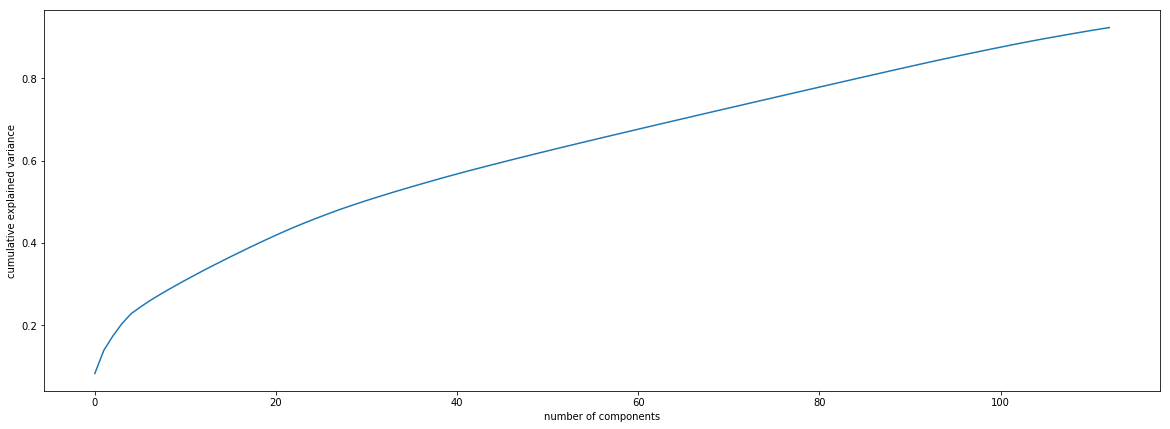

In [71]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Discussion 2.2: Perform Dimensionality Reduction

During our PCA analysis, we see that we can obtain 90% of the variance if we go up to 113 features. Therefore we will use 113 features for our analysis going forward. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def calc_weights(x, pca): 
    column_list = azdias_under.columns.values.tolist()

    df = pd.DataFrame(pca.components_,  columns = column_list)
    weights = df.iloc[x].sort_values(ascending=False)

    return weights

In [73]:
print(calc_weights(0, pca))

rs_low_income_earners                0.188517
HH_EINKOMMEN_SCORE                   0.180134
household                            0.179783
PLZ8_ANTG3                           0.179084
PLZ8_ANTG4                           0.173854
PLZ8_BAUMAX                          0.169722
ORTSGR_KLS9                          0.152986
EWDICHTE                             0.151457
FINANZ_HAUSBAUER                     0.147253
fs_low_income_earners                0.127153
KBA05_ANTG4                          0.124298
PLZ8_ANTG2                           0.122757
ANZ_HAUSHALTE_AKTIV                  0.113077
ARBEIT                               0.111446
KBA05_ANTG3                          0.110951
urban_working_class                  0.110065
fs_orientation_low_income_earners    0.105636
RELAT_AB                             0.105267
fs_single                            0.101961
rs_single                            0.101961
low_financial_interest               0.101098
FINANZ_SPARER                     

In [74]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(calc_weights(1, pca))


ALTERSKATEGORIE_GROB                   0.237794
FINANZ_VORSORGER                       0.223732
fair_supplied                          0.199388
SEMIO_ERL                              0.181440
SEMIO_LUST                             0.167149
RETOURTYP_BK_S                         0.155591
W_KEIT_KIND_HH                         0.128024
consumption_traditionalist             0.111384
FINANZ_MINIMALIST                      0.102919
money_saver                            0.097786
investor                               0.097308
fs_low_income_earners                  0.084192
demanding_shopper                      0.075046
FINANZ_HAUSBAUER                       0.073859
german_sounding                        0.071714
consumption_minimalist                 0.071668
SEMIO_KRIT                             0.070765
inconspicuous                          0.068293
fs_single                              0.065626
rs_single                              0.065626
culture_lovers                         0

In [75]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(calc_weights(2, pca))


SEMIO_VERT                           0.315477
SEMIO_FAM                            0.255283
SEMIO_SOZ                            0.254594
SEMIO_KULT                           0.246931
investor                             0.136701
FINANZ_MINIMALIST                    0.131425
external_supplied_hedonist           0.121066
green                                0.120985
SEMIO_REL                            0.109336
GREEN_AVANTGARDE                     0.088794
SEMIO_MAT                            0.087482
movement                             0.086043
RETOURTYP_BK_S                       0.072495
ORTSGR_KLS9                          0.072272
EWDICHTE                             0.071689
fs_houseowners                       0.064762
rs_top_earners                       0.064762
W_KEIT_KIND_HH                       0.056426
PLZ8_BAUMAX                          0.055273
shopping_stressed                    0.053769
PLZ8_ANTG4                           0.053306
PLZ8_ANTG3                        

### Discussion 2.3: Interpret Principal Components
Weights across each of the top 3 components make up a varied composition. Building types look they are the dominate factor in the first component, while Personality traits have both a strong and negligible effect on the 3rd component. The second is made up of a mix of their age bracket, event-oriented personality trait, and a be-prepared financial mindset. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

def cluster_data(num_clusters, data):
    model = KMeans(n_clusters = num_clusters, random_state = 15)
    score = np.abs(model.fit(data).score(data))
    
    return score

In [77]:
'''
score_list = []
for i in range(1,15):
    distance = cluster_data(i, X_pca)
    score_list.append(distance)
    
print(score_list)
'''

'\nscore_list = []\nfor i in range(1,15):\n    distance = cluster_data(i, X_pca)\n    score_list.append(distance)\n    \nprint(score_list)\n'

In [78]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#plt.plot(score_list)
#plt.show()


In [79]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kaz_model = KMeans(n_clusters=9, random_state = 15).fit(X_pca)
az_pred = kaz_model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population
Looking at the return score from the clustering we get a decent spread of numbers. I choose 6 clusters as seeming to be the best set as things start to even out about that point much more than earlier cluster positions. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [99]:
# Load in the customer demographics data.
customer_df = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [100]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cust_df_copy = clean_data(customer_df, col_list)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [101]:
"""
cust_df_test = cust_df_copy.astype(float)
imp = Imputer(strategy="mean")
cust_df_test_imputed = imp.fit_transform(cust_df_test)
feat_scale = StandardScaler(with_mean=0, with_std=1)
feat_scale.fit_transform(cust_df_test_imputed)

pca2, X_pca2 = run_pca(5, cust_df_test_imputed)

cust_pred = kaz_model.predict(X_pca2)
"""

'\ncust_df_test = cust_df_copy.astype(float)\nimp = Imputer(strategy="mean")\ncust_df_test_imputed = imp.fit_transform(cust_df_test)\nfeat_scale = StandardScaler(with_mean=0, with_std=1)\nfeat_scale.fit_transform(cust_df_test_imputed)\n\npca2, X_pca2 = run_pca(5, cust_df_test_imputed)\n\ncust_pred = kaz_model.predict(X_pca2)\n'

In [102]:
cust_df_test = cust_df_copy.astype(float)
cust_df_test_imputed = imp.transform(cust_df_test)

cust_set = feat_scale.transform(cust_df_test_imputed)

X_pca2 = pca.transform(cust_set)
#cust_pred = KMeans(n_clusters=9, random_state = 15).predict(X_pca2)
cust_pred = kaz_model.predict(X_pca2)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [150]:
df_az_pred = pd.DataFrame(az_pred)
df_cust_pred = pd.DataFrame(cust_pred)

In [151]:
df_az_pred = df_az_pred.rename(columns={0:'clusters'})
df_cust_pred = df_cust_pred.rename(columns={0:'clusters'})

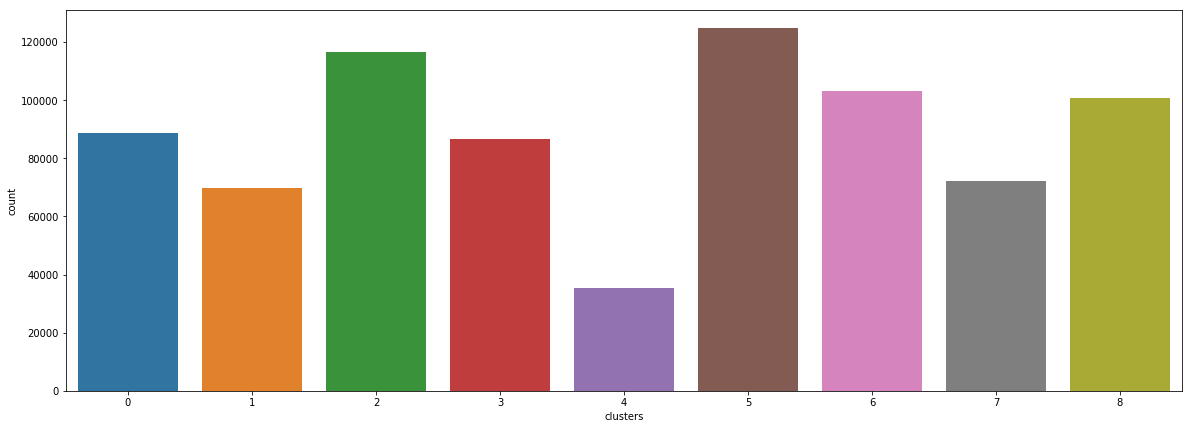

In [152]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

sns.countplot(x='clusters', data=df_az_pred)

plt.show()

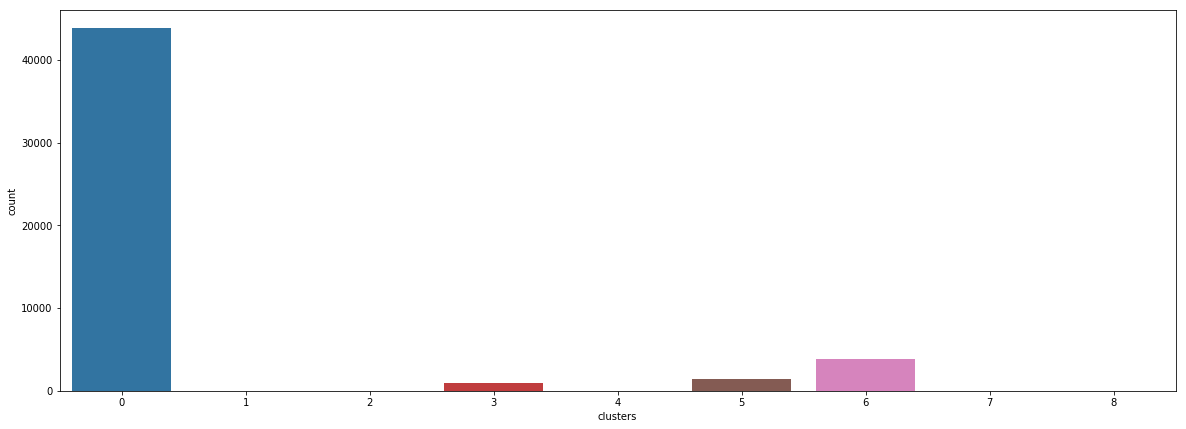

In [153]:
sns.countplot(x='clusters', data=df_cust_pred)

plt.show()

In [105]:
def calc_weights_cust(x, pca): 
    column_list = cust_df_copy.columns.values.tolist()

    df = pd.DataFrame(pca.components_,  columns = column_list)
    weights = df.iloc[x].sort_values(ascending=False)

    return weights

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
calc_weights_cust(0, pca).head()

rs_low_income_earners    0.188517
HH_EINKOMMEN_SCORE       0.180134
household                0.179783
PLZ8_ANTG3               0.179084
PLZ8_ANTG4               0.173854
Name: 0, dtype: float64

In [107]:
calc_weights(0, pca).head()

rs_low_income_earners    0.188517
HH_EINKOMMEN_SCORE       0.180134
household                0.179783
PLZ8_ANTG3               0.179084
PLZ8_ANTG4               0.173854
Name: 0, dtype: float64

In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
calc_weights_cust(2, pca).head()

SEMIO_VERT    0.315477
SEMIO_FAM     0.255283
SEMIO_SOZ     0.254594
SEMIO_KULT    0.246931
investor      0.136701
Name: 2, dtype: float64

In [109]:
calc_weights(2, pca).head()

SEMIO_VERT    0.315477
SEMIO_FAM     0.255283
SEMIO_SOZ     0.254594
SEMIO_KULT    0.246931
investor      0.136701
Name: 2, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data
Looking at our clusters we do see that there are two that stand out. The first cluster makes up a larger portion of the customer dataset than the general population dataset while the 2nd cluster makes up a larger portion of the general population as opposed to the customer set. 

Below are the sets that make up the first cluster more in the customer dataset as opposed to the general population: <br>
FINANZ_HAUSBAUER | Home Ownership <br>
PLZ8_ANTG3 | Region w/ 6-10 family houses<br>
PLZ8_BAUMAX | Common building type<br>
PLZ8_ANTG4 | Region w/ 10 family houses<br>
HH_EINKOMMEN_SCORE | Estimated Household net income<br>

This cluster would appear to show customers that own their home and live in areas with lot of family houses. The two clusters are fairly similiar but make up a heavier part of the dataset for customers. 

For the 3rd cluster: 

Customers: <br>
FINANZ_SPARER | Financial trait money-saver<br>
decade | Decade of person's dominating movement<br>
FINANZ_ANLEGER | investor<br>
SEMIO_PFLICHT | Personality trait dutiful<br>
SEMIO_RAT | Personality trait rational<br>

Population:<br>
SEMIO_VERT | Personality trait Dreamer<br>
SEMIO_SOZ | Personality trait Socially-minded<br>
SEMIO_FAM | Personality trait Family-minded<br>
SEMIO_KULT | Personality trait Cultural minded<br>
FINANZ_MINIMALIST | Finanicial trait low financial interest<br>

It would appear that there is a large difference between the kind of person in the general population for this cluster as opposed to the customer base. This cluster for the shows a customer base of probably more traditional, high income workers while the the population set has more family oriented, probably more lower-middle class workers. The one thing that seems to be showing in the data is that individuals with higher incomes and more financial discipline are more likely to be customers of this company than other individuals within the general population. With this information, the company should look to find individuals in the upper income scale to focus on as opposed to those in lower income brackets. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.